# Notebook 2: Wrangling & Feature Engineering

**Phases 4-5:** Data Wrangling & Transformation, Feature Engineering & Aggregation

**Dataset:** NYC Taxi Trip Dataset (continuing from Notebook 1)

**Focus:** Transforming and enriching data - merging datasets, working with datetime data, reshaping, and creating features for modeling.

---

## Phase 4: Data Wrangling & Transformation

### Learning Objectives
- Merge and join multiple datasets
- Handle datetime columns and set datetime index
- Extract time-based features
- Reshape data for analysis
- Work with indexes

### Step 1: Load Cleaned Data from Previous Notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load cleaned data from Notebook 1
df = pd.read_csv('../output/01_cleaned_taxi_data.csv')
print(f"Loaded {len(df):,} cleaned taxi trips")
print(f"Date range: {df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}")

# Check if location IDs are available (they should be if using real NYC TLC data)
if 'PULocationID' in df.columns and 'DOLocationID' in df.columns:
    print(f"✓ Location IDs found: {df['PULocationID'].nunique()} unique pickup zones, {df['DOLocationID'].nunique()} unique dropoff zones")
else:
    print("⚠️  Note: PULocationID/DOLocationID not found - zone lookup will be limited")

Loaded 2,880,957 cleaned taxi trips
Date range: 2022-10-25 00:42:10 to 2023-02-01 00:56:53
✓ Location IDs found: 254 unique pickup zones, 261 unique dropoff zones


### Step 2: Convert to Datetime and Set Datetime Index

In [2]:
# Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Recalculate trip_duration if needed
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Set pickup_datetime as index for datetime-based operations
df_ts = df.set_index('pickup_datetime').sort_index()

print(f"Datetime index set. Shape: {df_ts.shape}")
print(f"Index range: {df_ts.index.min()} to {df_ts.index.max()}")
display(df_ts.head())

Datetime index set. Shape: (2880957, 20)
Index range: 2022-10-25 00:42:10 to 2023-02-01 00:56:53


,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,pickup_date
pickup_datetime,,,,,,,,,,,,,,,,,,,,
2022-10-25 00:42:10,2,2022-10-25 00:44:22,1.0,0.97,1.0,N,132,132,2,4.5,0.0,0.5,0.00,0.0,0.3,5.00,0.0,1.25,2.200000,2022-10-25
2022-10-25 00:59:02,2,2022-10-25 01:09:02,1.0,2.33,1.0,N,265,265,2,10.0,0.0,0.5,0.00,0.0,0.3,10.50,0.0,0.00,10.000000,2022-10-25
2022-10-25 03:45:46,2,2022-10-25 03:45:50,1.0,0.02,5.0,N,1,1,1,115.0,0.0,0.0,5.00,0.0,0.3,120.50,0.0,0.00,0.066667,2022-10-25
2022-10-25 07:48:15,2,2022-10-25 07:48:18,2.0,0.76,5.0,N,132,264,1,78.0,0.0,0.5,15.76,0.0,0.3,94.26,0.0,0.00,0.050000,2022-10-25
2022-10-25 09:06:23,2,2022-10-25 09:21:36,1.0,6.48,1.0,N,132,38,2,19.5,0.0,0.5,0.00,0.0,0.3,20.00,0.0,1.25,15.216667,2022-10-25


### Step 3: Extract Time-Based Features

**Why extract time-based features?**
- **Temporal patterns:** Hour, day of week, and month reveal important patterns (rush hours, weekends, seasons)
- **Modeling:** Time features are often strong predictors (e.g., fare varies by time of day)
- **Analysis:** Enable grouping and aggregation by time periods

**What time features to extract?**
- **Hour (0-23):** Captures daily patterns (morning rush, lunch, evening)
- **Day of week (0-6):** Captures weekly patterns (weekdays vs weekends)
- **Month (1-12):** Captures seasonal patterns
- **Derived features:** Weekend flag, time-of-day categories, etc.

In [3]:
# Extract various time-based features from the datetime index
df_ts['hour'] = df_ts.index.hour
df_ts['day_of_week'] = df_ts.index.dayofweek  # 0=Monday, 6=Sunday
df_ts['day_name'] = df_ts.index.day_name()
df_ts['month'] = df_ts.index.month
df_ts['month_name'] = df_ts.index.month_name()
df_ts['year'] = df_ts.index.year
df_ts['is_weekend'] = df_ts['day_of_week'].isin([5, 6]).astype(int)

# Create time-of-day categories
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_ts['time_of_day'] = df_ts['hour'].apply(get_time_of_day)

print("Time-based features extracted:")
print(df_ts[['hour', 'day_of_week', 'day_name', 'month', 'is_weekend', 'time_of_day']].head(10))

Time-based features extracted:
                     hour  day_of_week  day_name  month  is_weekend  \
pickup_datetime                                                       
2022-10-25 00:42:10     0            1   Tuesday     10           0   
2022-10-25 00:59:02     0            1   Tuesday     10           0   
2022-10-25 03:45:46     3            1   Tuesday     10           0   
2022-10-25 07:48:15     7            1   Tuesday     10           0   
2022-10-25 09:06:23     9            1   Tuesday     10           0   
2022-10-25 13:03:37    13            1   Tuesday     10           0   
2022-12-31 14:24:54    14            5  Saturday     12           1   
2022-12-31 14:39:43    14            5  Saturday     12           1   
2022-12-31 15:14:12    15            5  Saturday     12           1   
2022-12-31 22:02:51    22            5  Saturday     12           1   

                    time_of_day  
pickup_datetime                  
2022-10-25 00:42:10       Night  
2022-10-25 00:

### Step 4: Merge with Additional Data (Zone Lookup Table)

**Note:** NYC TLC data includes `PULocationID` and `DOLocationID` columns. We'll load the official NYC Taxi Zone lookup table (downloaded by `download_data.sh`) and merge it with the trip data to add zone names and boroughs.

In [4]:
# Verify that location IDs are present in the data
# Real NYC TLC data includes PULocationID and DOLocationID columns
if 'PULocationID' not in df_ts.columns or 'DOLocationID' not in df_ts.columns:
    raise ValueError("PULocationID and DOLocationID columns not found in data. This is required for zone lookup merge.")

# Load official NYC Taxi Zone Lookup Table
# This file is downloaded by download_data.sh and contains all 265 zones with official names
zone_lookup_file = 'data/taxi_zone_lookup.csv'

if not os.path.exists(zone_lookup_file):
    print("❌ Zone lookup file not found!")
    print("Please run download_data.sh to download the zone lookup file:")
    print("  chmod +x download_data.sh")
    print("  ./download_data.sh")
    raise FileNotFoundError(f"Zone lookup file not found: {zone_lookup_file}. Run download_data.sh first.")

# Load official zone lookup file
zone_lookup = pd.read_csv(zone_lookup_file)
# Rename columns to match our merge needs
# Drop 'service_zone' to avoid duplicate columns when merging pickup and dropoff
zone_lookup = zone_lookup.rename(columns={'Zone': 'zone_name'}).drop(columns=['service_zone'], errors='ignore')
print(f"✅ Loaded official zone lookup: {len(zone_lookup)} zones")
print(f"   Columns: {list(zone_lookup.columns)}")
print(f"   Sample zones: {zone_lookup[['LocationID', 'Borough', 'zone_name']].head(5).to_string(index=False)}")

# Use actual location IDs from the real NYC TLC data
# Real data includes PULocationID and DOLocationID columns
df_ts_reset = df_ts.reset_index()

if 'PULocationID' in df_ts_reset.columns and 'DOLocationID' in df_ts_reset.columns:
    # Rename to match zone_lookup column name for merging
    df_ts_reset = df_ts_reset.rename(columns={'PULocationID': 'pickup_zone_id', 'DOLocationID': 'dropoff_zone_id'})
    print("✓ Using real location IDs from NYC TLC data")
    print(f"  Pickup zones: {df_ts_reset['pickup_zone_id'].nunique()} unique")
    print(f"  Dropoff zones: {df_ts_reset['dropoff_zone_id'].nunique()} unique")
else:
    # This should never execute - we check for PULocationID/DOLocationID above and raise ValueError if missing
    # If we somehow get here, we can't do zone assignment without location IDs
    raise ValueError("PULocationID/DOLocationID columns are required but not found. This should not happen with real NYC TLC data.")

# Merge pickup zone information using LEFT JOIN
# LEFT JOIN keeps all rows from left DataFrame (df_ts), adds matching data from right (zone_lookup)
# This is the most common join type - we want all trips, even if zone info is missing
# IMPORTANT: Reset index before merge, then set it back to preserve DatetimeIndex

if 'pickup_zone_id' in df_ts_reset.columns:
    # Merge pickup zone information using LEFT JOIN
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'pickup_zone_id', 'zone_name': 'pickup_zone_name', 'Borough': 'pickup_borough'}),
        on='pickup_zone_id',
        how='left'  # LEFT JOIN: keep all trips, add zone info where available
    )
    
    # Merge dropoff zone information
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'dropoff_zone_id', 'zone_name': 'dropoff_zone_name', 'Borough': 'dropoff_borough'}),
        on='dropoff_zone_id',
        how='left'  # LEFT JOIN: keep all trips
    )
    
    print("\n✅ Zone information merged:")
    print(f"   Total columns: {df_ts_reset.shape[1]}")
    print(f"   Zones matched: {df_ts_reset['pickup_zone_name'].notna().sum():,} / {len(df_ts_reset):,} trips")
    if 'pickup_zone_name' in df_ts_reset.columns:
        print("\nSample zone information:")
        display(df_ts_reset[['pickup_zone_name', 'pickup_borough', 'dropoff_zone_name', 'dropoff_borough']].head(10))
else:
    print("⚠️  Zone merge skipped - location IDs not available in data")

# Set datetime index back
df_ts = df_ts_reset.set_index('pickup_datetime').sort_index()

# Demonstrate other join types (for educational purposes)
print("\n" + "=" * 60)
print("JOIN TYPE EXAMPLES (Educational)")
print("=" * 60)

# Create example DataFrames to demonstrate join types
left_df = pd.DataFrame({'key': [1, 2, 3, 4], 'left_value': ['A', 'B', 'C', 'D']})
right_df = pd.DataFrame({'key': [2, 3, 4, 5], 'right_value': ['X', 'Y', 'Z', 'W']})

print("Left DataFrame:")
display(left_df)
print("\nRight DataFrame:")
display(right_df)

# INNER JOIN: Only rows with matching keys in both DataFrames
inner_result = pd.merge(left_df, right_df, on='key', how='inner')
print("\nINNER JOIN (only matching keys):")
display(inner_result)

# LEFT JOIN: All rows from left, matching from right
left_result = pd.merge(left_df, right_df, on='key', how='left')
print("\nLEFT JOIN (all from left, matching from right):")
display(left_result)

# RIGHT JOIN: All rows from right, matching from left
right_result = pd.merge(left_df, right_df, on='key', how='right')
print("\nRIGHT JOIN (all from right, matching from left):")
display(right_result)

# OUTER JOIN: All rows from both DataFrames
outer_result = pd.merge(left_df, right_df, on='key', how='outer')
print("\nOUTER JOIN (all rows from both):")
display(outer_result)

✅ Loaded official zone lookup: 265 zones
   Columns: ['LocationID', 'Borough', 'zone_name']
   Sample zones:  LocationID       Borough               zone_name
          1           EWR          Newark Airport
          2        Queens             Jamaica Bay
          3         Bronx Allerton/Pelham Gardens
          4     Manhattan           Alphabet City
          5 Staten Island           Arden Heights


✓ Using real location IDs from NYC TLC data
  Pickup zones: 254 unique
  Dropoff zones: 261 unique



✅ Zone information merged:
   Total columns: 33
   Zones matched: 2,843,533 / 2,880,957 trips

Sample zone information:


,pickup_zone_name,pickup_borough,dropoff_zone_name,dropoff_borough
0,JFK Airport,Queens,JFK Airport,Queens
1,Outside of NYC,NaN,Outside of NYC,NaN
2,Newark Airport,EWR,Newark Airport,EWR
3,JFK Airport,Queens,NaN,Unknown
4,JFK Airport,Queens,Cambria Heights,Queens
5,LaGuardia Airport,Queens,NaN,Unknown
6,Clinton East,Manhattan,Midtown North,Manhattan
7,Midtown North,Manhattan,Midtown East,Manhattan
8,Queensbridge/Ravenswood,Queens,Astoria,Queens
9,East Village,Manhattan,Upper West Side North,Manhattan



JOIN TYPE EXAMPLES (Educational)
Left DataFrame:


,key,left_value
0,1,A
1,2,B
2,3,C
3,4,D



Right DataFrame:


,key,right_value
0,2,X
1,3,Y
2,4,Z
3,5,W



INNER JOIN (only matching keys):


,key,left_value,right_value
0,2,B,X
1,3,C,Y
2,4,D,Z



LEFT JOIN (all from left, matching from right):


,key,left_value,right_value
0,1,A,NaN
1,2,B,X
2,3,C,Y
3,4,D,Z



RIGHT JOIN (all from right, matching from left):


,key,left_value,right_value
0,2,B,X
1,3,C,Y
2,4,D,Z
3,5,NaN,W



OUTER JOIN (all rows from both):


,key,left_value,right_value
0,1,A,NaN
1,2,B,X
2,3,C,Y
3,4,D,Z
4,5,NaN,W


### Step 5: Reshape Data - Pivot Table Example

Average Fare by Day of Week and Time of Day:


time_of_day,Afternoon,Evening,Morning,Night
day_name,,,,
Friday,18.95,17.16,18.12,18.52
Monday,19.38,18.71,19.05,22.41
Saturday,17.77,17.69,17.44,17.16
Sunday,20.02,20.20,19.57,19.14
Thursday,19.12,17.38,17.69,19.27
Tuesday,19.13,17.19,18.00,20.16
Wednesday,18.34,16.88,17.79,19.57


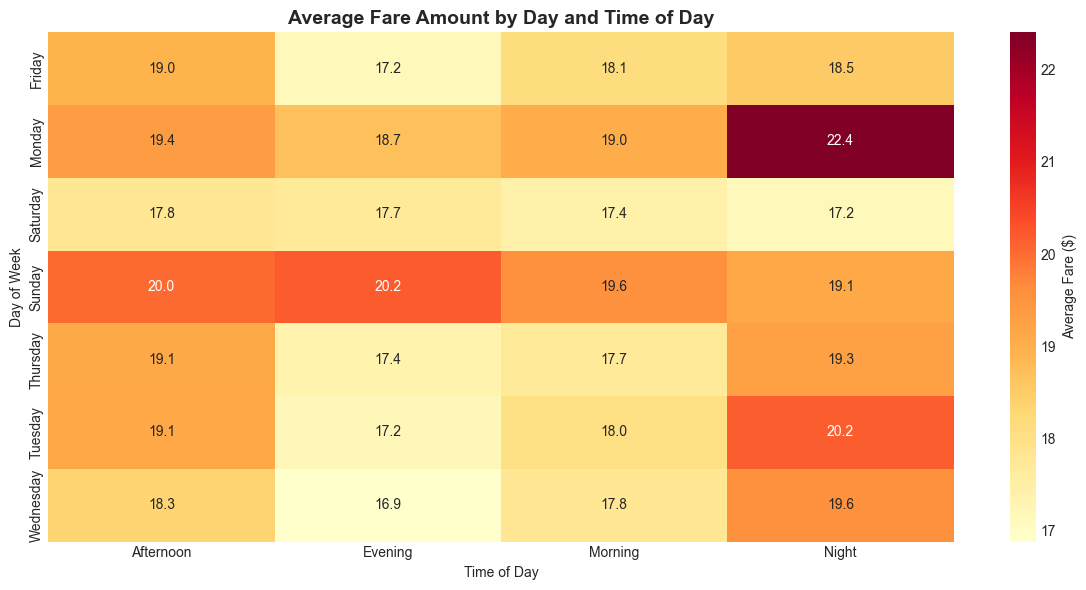

In [5]:
# Create a pivot table: Average fare by day of week and time of day
pivot_fare = df_ts.pivot_table(
    values='fare_amount',
    index='day_name',
    columns='time_of_day',
    aggfunc='mean'
)

print("Average Fare by Day of Week and Time of Day:")
display(pivot_fare.round(2))

# Visualize the pivot table
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_fare, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Fare ($)'})
plt.title('Average Fare Amount by Day and Time of Day', fontsize=14, fontweight='bold')
plt.xlabel('Time of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

### Step 6: Reshape Data - Melt Example

In [6]:
# Example: Convert wide format to long format
# Let's create a summary by hour with multiple metrics

hourly_summary = df_ts.groupby('hour').agg({
    'fare_amount': 'mean',
    'trip_distance': 'mean',
    'trip_duration': 'mean',
    'passenger_count': 'mean'
}).reset_index()

print("Hourly Summary (Wide Format):")
display(hourly_summary.head())

# Melt to long format
hourly_long = hourly_summary.melt(
    id_vars='hour',
    value_vars=['fare_amount', 'trip_distance', 'trip_duration', 'passenger_count'],
    var_name='metric',
    value_name='value'
)

print("\nHourly Summary (Long Format):")
display(hourly_long.head(10))

Hourly Summary (Wide Format):


,hour,fare_amount,trip_distance,trip_duration,passenger_count
0,0,19.782035,4.026395,13.434522,1.444195
1,1,17.819408,3.493215,12.457550,1.455881
2,2,16.719067,3.215587,11.846226,1.465109
3,3,17.713652,3.501926,11.909199,1.435960
4,4,22.247158,4.670487,13.218453,1.408720



Hourly Summary (Long Format):


,hour,metric,value
0,0,fare_amount,19.782035
1,1,fare_amount,17.819408
2,2,fare_amount,16.719067
3,3,fare_amount,17.713652
4,4,fare_amount,22.247158
5,5,fare_amount,26.407740
6,6,fare_amount,22.114478
7,7,fare_amount,18.899377
8,8,fare_amount,17.411270
9,9,fare_amount,17.595267


---

## Phase 5: Feature Engineering & Aggregation

### Learning Objectives
- Create derived features
- Perform groupby aggregations
- Calculate rolling window statistics
- Create time-based features
- Aggregate by multiple dimensions

### Step 1: Create Derived Features

In [7]:
# Speed (miles per hour) - derived from distance and duration
df_ts['speed_mph'] = df_ts['trip_distance'] / (df_ts['trip_duration'] / 60)  # Convert minutes to hours
df_ts['speed_mph'] = df_ts['speed_mph'].replace([np.inf, -np.inf], np.nan)  # Handle division by zero
df_ts['speed_mph'] = df_ts['speed_mph'].clip(upper=60)  # Cap at 60 mph (reasonable for NYC)

# Fare per mile
df_ts['fare_per_mile'] = df_ts['fare_amount'] / df_ts['trip_distance']
df_ts['fare_per_mile'] = df_ts['fare_per_mile'].replace([np.inf, -np.inf], np.nan)

# Tip percentage
df_ts['tip_percentage'] = (df_ts['tip_amount'] / df_ts['fare_amount']) * 100
df_ts['tip_percentage'] = df_ts['tip_percentage'].fillna(0)  # No tip = 0%

# Distance category
def categorize_distance(dist):
    if dist < 1:
        return 'Short'
    elif dist < 3:
        return 'Medium'
    elif dist < 10:
        return 'Long'
    else:
        return 'Very Long'

df_ts['distance_category'] = df_ts['trip_distance'].apply(categorize_distance)

print("Derived features created:")
print(df_ts[['speed_mph', 'fare_per_mile', 'tip_percentage', 'distance_category']].head(10))

Derived features created:
                     speed_mph  fare_per_mile  tip_percentage  \
pickup_datetime                                                 
2022-10-25 00:42:10  26.454545       4.639175        0.000000   
2022-10-25 00:59:02  13.980000       4.291845        0.000000   
2022-10-25 03:45:46  18.000000    5750.000000        4.347826   
2022-10-25 07:48:15  60.000000     102.631579       20.205128   
2022-10-25 09:06:23  25.550931       3.009259        0.000000   
2022-10-25 13:03:37  60.000000     281.818182       25.322581   
2022-12-31 14:24:54   2.339144      24.390244        0.000000   
2022-12-31 14:39:43   8.307692      10.740741       37.241379   
2022-12-31 15:14:12   8.129032       6.948052        0.000000   
2022-12-31 22:02:51  18.187013       4.614396       22.785515   

                    distance_category  
pickup_datetime                        
2022-10-25 00:42:10             Short  
2022-10-25 00:59:02            Medium  
2022-10-25 03:45:46             S

### Step 2: GroupBy Aggregations

**What is GroupBy?**
GroupBy splits data into groups, applies a function to each group, and combines the results. It's one of pandas' most powerful features for data analysis.

**Why use GroupBy?**
- **Summarize:** Calculate statistics for each group (e.g., average fare by day of week)
- **Compare:** See how metrics differ across groups
- **Aggregate:** Reduce data size while preserving important patterns
- **Explore:** Discover relationships between categorical and numeric variables

**Common GroupBy operations:**
- **Single column:** `groupby('day_of_week')` - group by one variable
- **Multiple columns:** `groupby(['day_of_week', 'time_of_day'])` - group by multiple variables
- **Multiple functions:** `agg({'fare': 'mean', 'distance': 'sum'})` - different functions for different columns

In [8]:
# Aggregate by day of week
daily_stats = df_ts.groupby('day_name').agg({
    'fare_amount': ['mean', 'median', 'std', 'count'],
    'trip_distance': ['mean', 'median'],
    'trip_duration': ['mean', 'median'],
    'passenger_count': 'mean'
}).round(2)

print("Statistics by Day of Week:")
display(daily_stats)

# Aggregate by multiple dimensions: day of week and time of day
multi_agg = df_ts.groupby(['day_name', 'time_of_day']).agg({
    'fare_amount': 'mean',
    'trip_distance': 'count'  # Count of trips
}).rename(columns={'fare_amount': 'avg_fare', 'trip_distance': 'trip_count'})

print("\nAverage Fare by Day and Time:")
display(multi_agg.head(15))

Statistics by Day of Week:


fare_amount                       trip_distance         \
                 mean median    std   count          mean median   
day_name                                                           
Friday          18.20   12.8  16.41  408722          3.29   1.76   
Monday          19.59   12.8  18.94  379963          3.82   1.84   
Saturday        17.51   12.8  15.37  416137          3.15   1.81   
Sunday          19.71   12.8  18.51  407897          3.88   2.00   
Thursday        18.32   12.8  16.41  414650          3.25   1.74   
Tuesday         18.47   12.8  16.83  461950          3.34   1.75   
Wednesday       17.99   12.8  16.14  391638          3.22   1.73   

          trip_duration        passenger_count  
                   mean median            mean  
day_name                                        
Friday            14.83  11.70            1.39  
Monday            14.31  11.02            1.37  
Saturday          13.75  11.33            1.48  
Sunday            13.82  11.07            1.47  
Thursday          15.24  12.12            1.34  
Tuesday           14.83  11.72            1.33  
Wednesday         14.62  11.73            1.33


Average Fare by Day and Time:


avg_fare  trip_count
day_name time_of_day                       
Friday   Afternoon    18.951536      119627
         Evening      17.158765      106938
         Morning      18.118853       90462
         Night        18.524376       91695
Monday   Afternoon    19.384717      126134
         Evening      18.706911       99601
         Morning      19.046068       95767
         Night        22.405648       58461
Saturday Afternoon    17.774309      121978
         Evening      17.692605      100541
         Morning      17.437026       65059
         Night        17.155291      128559
Sunday   Afternoon    20.022975      127601
         Evening      20.198113       86573
         Morning      19.570010       68062

### Step 3: Rolling Window Calculations

**What are rolling windows?**
Rolling windows calculate statistics over a sliding window of time periods. For example, a 7-day rolling mean calculates the average of the current day and the previous 6 days.

**Why use rolling windows?**
- **Smooth trends:** Remove daily noise to see underlying patterns
- **Moving averages:** Common in time series analysis
- **Trend detection:** Identify increasing/decreasing trends
- **Anomaly detection:** Compare current values to rolling statistics

**Common rolling window operations:**
- **Rolling mean:** Average over window (smooths data)
- **Rolling median:** Median over window (robust to outliers)
- **Rolling std:** Standard deviation over window (measures volatility)
- **Rolling min/max:** Min/max over window (identifies extremes)

**Window size considerations:**
- **Small windows (3-7 days):** Capture short-term patterns, more responsive to changes
- **Large windows (30+ days):** Capture long-term trends, smoother but less responsive

Rolling window calculations:


,fare_amount,fare_7d_avg,fare_30d_avg,fare_ewm
pickup_datetime,,,,
2022-10-25 00:00:00,7.25,7.2500,7.2500,7.250000
2022-10-25 01:00:00,NaN,7.2500,7.2500,7.250000
2022-10-25 02:00:00,NaN,7.2500,7.2500,7.250000
2022-10-25 03:00:00,115.00,61.1250,61.1250,8.555501
2022-10-25 04:00:00,NaN,61.1250,61.1250,8.555501
2022-10-25 05:00:00,NaN,61.1250,61.1250,8.555501
2022-10-25 06:00:00,NaN,61.1250,61.1250,8.555501
2022-10-25 07:00:00,78.00,66.7500,66.7500,9.406845
2022-10-25 08:00:00,NaN,66.7500,66.7500,9.406845


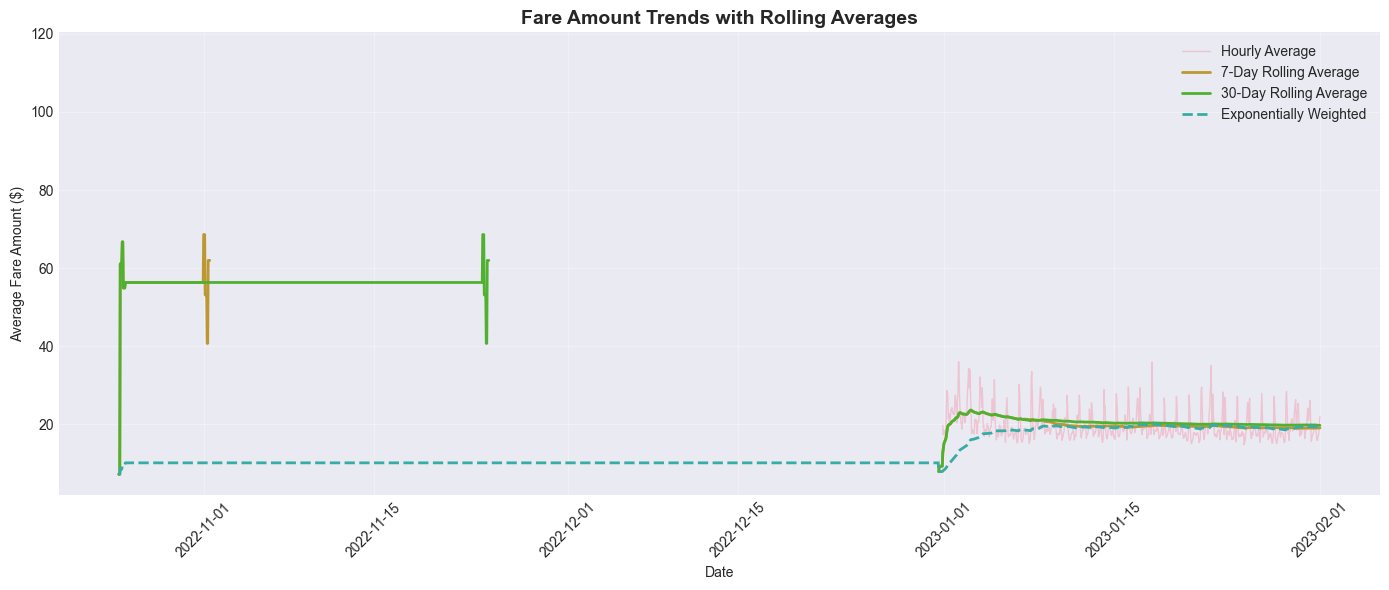

In [9]:
# Resample to hourly for rolling calculations
hourly_trips = df_ts.resample('h').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_trips.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_trips = hourly_trips[['fare_amount', 'trip_distance', 'total_amount', 'trip_count']]

# Calculate rolling averages (7-day and 30-day windows)
hourly_trips['fare_7d_avg'] = hourly_trips['fare_amount'].rolling(window=7*24, min_periods=1).mean()  # 7 days * 24 hours
hourly_trips['fare_30d_avg'] = hourly_trips['fare_amount'].rolling(window=30*24, min_periods=1).mean()  # 30 days * 24 hours

# Calculate exponentially weighted moving average
hourly_trips['fare_ewm'] = hourly_trips['fare_amount'].ewm(span=7*24, adjust=False).mean()

print("Rolling window calculations:")
display(hourly_trips[['fare_amount', 'fare_7d_avg', 'fare_30d_avg', 'fare_ewm']].head(20))

# Visualize rolling averages
plt.figure(figsize=(14, 6))
plt.plot(hourly_trips.index, hourly_trips['fare_amount'], alpha=0.3, label='Hourly Average', linewidth=1)
plt.plot(hourly_trips.index, hourly_trips['fare_7d_avg'], label='7-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_30d_avg'], label='30-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_ewm'], label='Exponentially Weighted', linewidth=2, linestyle='--')
plt.title('Fare Amount Trends with Rolling Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Fare Amount ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 4: Time-Based Aggregations

Hourly Patterns (aggregated across all days):


,fare_amount,trip_count,trip_distance,total_amount
hour,,,,
0,19.782035,79429,4.026395,1892993.04
1,17.819408,55464,3.493215,1197031.28
2,16.719067,38649,3.215587,781579.54
3,17.713652,25000,3.501926,531947.74
4,22.247158,15803,4.670487,414141.87
5,26.407740,16122,5.959968,496468.98
6,22.114478,39907,4.771306,1041069.49
7,18.899377,79487,3.670283,1799725.63
8,17.411270,107775,3.069002,2268486.41


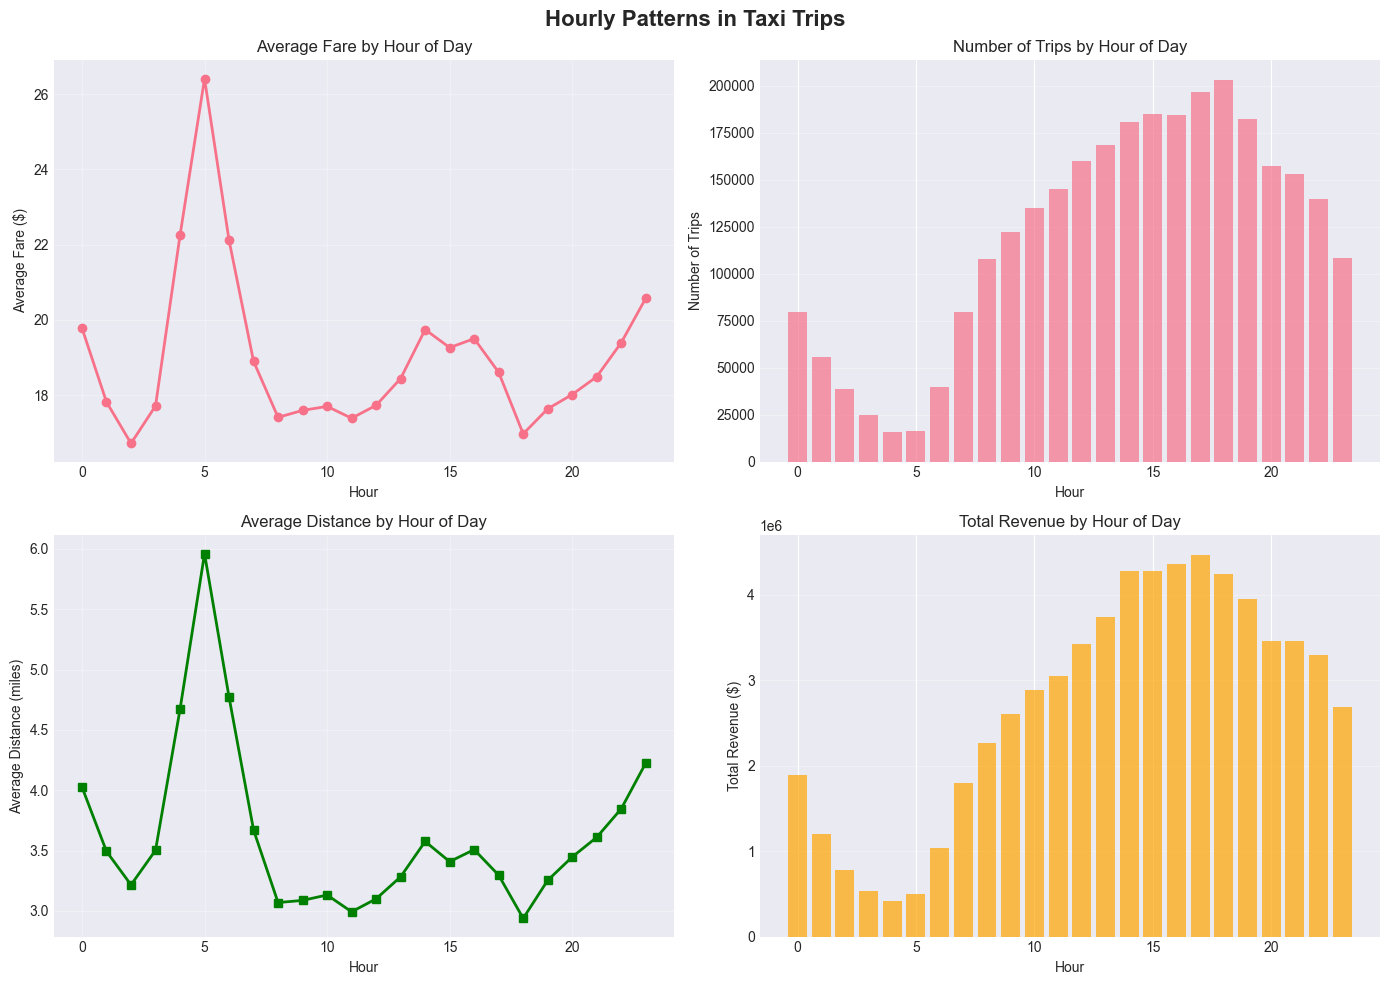

In [10]:
# Aggregate by hour of day (across all days)
hourly_pattern = df_ts.groupby('hour').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_pattern.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_pattern = hourly_pattern[['fare_amount', 'trip_count', 'trip_distance', 'total_amount']]

print("Hourly Patterns (aggregated across all days):")
display(hourly_pattern.head(10))

# Visualize hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hourly Patterns in Taxi Trips', fontsize=16, fontweight='bold')

# Average fare by hour
axes[0, 0].plot(hourly_pattern.index, hourly_pattern['fare_amount'], marker='o', linewidth=2)
axes[0, 0].set_title('Average Fare by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Fare ($)')
axes[0, 0].grid(True, alpha=0.3)

# Trip count by hour
axes[0, 1].bar(hourly_pattern.index, hourly_pattern['trip_count'], alpha=0.7)
axes[0, 1].set_title('Number of Trips by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average distance by hour
axes[1, 0].plot(hourly_pattern.index, hourly_pattern['trip_distance'], marker='s', color='green', linewidth=2)
axes[1, 0].set_title('Average Distance by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Distance (miles)')
axes[1, 0].grid(True, alpha=0.3)

# Total revenue by hour
axes[1, 1].bar(hourly_pattern.index, hourly_pattern['total_amount'], alpha=0.7, color='orange')
axes[1, 1].set_title('Total Revenue by Hour of Day')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 5: Cross-Tabulation

In [11]:
# Cross-tabulation: Day of week vs Time of day
crosstab = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    margins=True
)

print("Trip Count: Day of Week × Time of Day")
display(crosstab)

# Cross-tabulation with aggregation
crosstab_fare = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    values=df_ts['fare_amount'],
    aggfunc='mean',
    margins=True
).round(2)

print("\nAverage Fare: Day of Week × Time of Day")
display(crosstab_fare)

Trip Count: Day of Week × Time of Day


time_of_day,Afternoon,Evening,Morning,Night,All
day_name,,,,,
Friday,119627,106938,90462,91695,408722
Monday,126134,99601,95767,58461,379963
Saturday,121978,100541,65059,128559,416137
Sunday,127601,86573,68062,125661,407897
Thursday,123027,113244,102717,75662,414650
Tuesday,141427,123552,125633,71338,461950
Wednesday,119311,109706,98391,64230,391638
All,879105,740155,646091,615606,2880957



Average Fare: Day of Week × Time of Day


time_of_day,Afternoon,Evening,Morning,Night,All
day_name,,,,,
Friday,18.95,17.16,18.12,18.52,18.20
Monday,19.38,18.71,19.05,22.41,19.59
Saturday,17.77,17.69,17.44,17.16,17.51
Sunday,20.02,20.20,19.57,19.14,19.71
Thursday,19.12,17.38,17.69,19.27,18.32
Tuesday,19.13,17.19,18.00,20.16,18.47
Wednesday,18.34,16.88,17.79,19.57,17.99
All,18.98,17.79,18.20,19.12,18.53


### Step 6: Save Processed Data

In [12]:
# Reset index to make pickup_datetime a regular column again
df_processed = df_ts.reset_index()

# Save processed dataset for next notebook
df_processed.to_csv('../output/02_processed_taxi_data.csv', index=False)
print(f"\nProcessed data saved: {len(df_processed):,} trips")
print(f"Columns: {df_processed.shape[1]}")
print("\nReady for next phase: Pattern Analysis & Modeling Prep!")


Processed data saved: 2,880,957 trips
Columns: 37

Ready for next phase: Pattern Analysis & Modeling Prep!


---

## Summary

**What we accomplished:**

1. ✅ **Set datetime index** for time-based operations
2. ✅ **Extracted time-based features** (hour, day, month, etc.)
3. ✅ **Merged zone lookup data** using pandas merge
4. ✅ **Reshaped data** using pivot and melt
5. ✅ **Created derived features** (speed, fare per mile, etc.)
6. ✅ **Performed aggregations** by multiple dimensions
7. ✅ **Calculated rolling windows** for trend analysis
8. ✅ **Created time-based patterns** and visualizations

**Key Takeaways:**
- Datetime indexing enables time-based operations and aggregations
- Merging enriches data with additional context
- Feature engineering creates predictive signals
- Rolling windows reveal trends and patterns
- GroupBy aggregations summarize data at different levels

**Next:** Notebook 3 will focus on pattern analysis, advanced visualizations, and preparing data for modeling.
